In [80]:
import pde
import phasesep as ps
import tracker
import numpy as np
import random
from dask_jobqueue import HTCondorCluster
from dask.distributed import Client
import os

## Dask

In [22]:
cluster = HTCondorCluster(
    cores=8,
    memory="8GB",
    disk="8GB",
    processes=8,
    local_directory="$TMPDIR",
    log_directory="/home/ole.berendes/dasklogs",
    job_extra={"+MaxRunTime": 3600},
    extra=["--lifetime", "150m", "--lifetime-stagger", "4m"]
)

/home/ole.berendes/miniconda3/lib/python3.8/site-packages/distributed/node.py:160: UserWarning: Port 8787 is already in use.
Perhaps you already have a cluster running?
Hosting the HTTP server on port 30432 instead
  warnings.warn(


In [23]:
cluster.scale(cores=128)

In [75]:
cluster

In [76]:
client = Client(cluster)
client

<Client: 'tcp://134.76.97.134:12415' processes=40 threads=40, memory=37.20 GiB>

## PDE

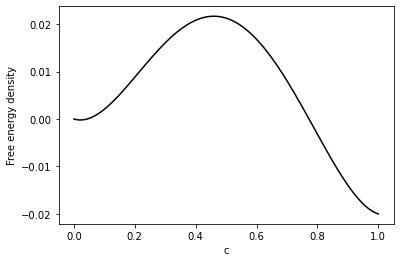

In [51]:
f_scale = 1
f_slope = -0.02
f_offset = 0

f = ps.GinzburgLandau2Components(
    prefactor=f_scale,
    slope=f_slope,
    offset=f_offset
)
f.plot()

In [52]:
kappa = 1
diffusive_mobility = 1
noise_diffusion = 2/30

eq = ps.CahnHilliardExtendedPDE(
    {
        "free_energy": f,
        "kappa": kappa,
        "mobility": diffusive_mobility,
        "noise_diffusion": noise_diffusion
    }
)
eq.cache_rhs = True

In [53]:
length_scale = 1

nx, ny = 32, 32
x_start, x_end = -nx/2*length_scale, nx/2*length_scale
y_start, y_end = -ny/2*length_scale, ny/2*length_scale
grid = pde.CartesianGrid(
    bounds=[(x_start, x_end), (y_start, y_end)],
    shape=[nx,ny],
    periodic=True)

## Simulation

In [62]:
datafile = "/home/ole.berendes/data/170222-SIM10/SIM10_263119.3_crossed_states.npz"
def load_data(file):
    archive = np.load(file, allow_pickle=True)
    arrs = []
    for i in range(len(archive)):
        arrs.append(archive[f"arr_{i}"].item())
    return arrs

In [63]:
crossing_states = client.submit(load_data, datafile)

In [64]:
dt = 1e-3
def single_traj(lam_start, lam_stop, initial_state, t_end=1e3, dt=dt, eq=eq):
    opar = tracker.DropletMaterialTracker(op_max=4, op_min=1.75, ncrossings=1)
    storage = pde.MemoryStorage(field_obj=initial_state, write_mode="truncate_once")
    stor = storage.tracker()
    eq.solve(
        state=initial_state,
        t_range=t_end,
        tracker=[stor, opar],
        method="explicit",
        dt=dt
    )

    return [opar.success, storage.data]
    


In [65]:
initial_state = client.submit(random.choice, crossing_states)

In [67]:
example_traj = client.submit(single_traj, 3, 4, initial_state)

In [ ]:
def ffs_iteration(
    initial_states,
    lam_start, lam_stop,
    trials, min_crossings,
    datadir,
    t_end=1e3, dt=dt, eq=eq,
    client = client
):

    def single_traj(
        lam_start=lam_start, lam_stop=lam_stop, 
        initial_states=initial_states,
        t_end=1e3, dt=dt, eq=eq
    ):
        initial_state = random.choice(initial_states)
        opar = tracker.DropletMaterialTracker(op_max=4, op_min=1.75, ncrossings=1)
        storage = pde.MemoryStorage(field_obj=initial_state, write_mode="truncate_once")
        stor = storage.tracker()
        final = eq.solve(
            state=initial_state,
            t_range=t_end,
            tracker=[stor, opar],
            method="explicit",
            dt=dt
        )

        return [opar.success, storage.data, final]

    ncrossings = 0
    trial = 0

    while ncrossings < min_crossings:
        futures = []
        for i in range(trials):
            fut = client.submit(single_traj)
            futures.append(fut)

        dir_out = os.path.join(datadir, f"LAM{lam_start}")
        if os.path.isdir() is False:
            os.mkdir(dir_out)
        results = client.gather(futures)
        crossed_states = []
        i = 0
        for res in results:
            if res[0] is True:
                crossed_states.append(res[2])
                file_out = os.path.join(dir_out, f"_trajectory_{i}.npz")
                np.savez_compressed(file_out, *res[1].data)
                i += 1
    

In [1]:
client.close()

NameError: name 'client' is not defined

In [2]:
cluster.close()

NameError: name 'cluster' is not defined